<a href="https://colab.research.google.com/github/brunokiyoshi/machine_learning/blob/master/RNN_stocks_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Import the training set
dataset_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RNN Stocks/Google_Stock_Price_Train.csv')
# Select the Open price column
training_set = dataset_train.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [7]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
print(training_set_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


In [30]:
# Create a data structure with X timesteps and 1 output
time_steps = 60
X_train = []
y_train = []
for i in range(time_steps, len(training_set_scaled)):
  X_train.append(training_set_scaled[i - time_steps:i, 0])
  y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
print(X_train[0])
print(y_train[0])

[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225 0.0643277
 0.0585423  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514
 0.02797827 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334
 0.01642607 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665
 0.0433812  0.04475779 0.04790163 0.0440695  0.04648783 0.04745517
 0.04873875 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099
 0.04356723 0.04286033 0.04602277 0.05398467 0.05738894 0.05714711
 0.05569611 0.04421832 0.04514845 0.04605997 0.04412531 0.03675869
 0.04486941 0.05065481 0.05214302 0.05612397 0.05818885 0.06540665
 0.06882953 0.07243843 0.07993526 0.07846566 0.08034452 0.08497656]
0.08627874097775134


In [ ]:
# Reshaping
# Keras recurrent layers require: (batch_size, timesteps, input_dims) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # 1 because I'm only using the Open price as input


In [39]:
# Building the RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


In [40]:
# Initialize the RNN
regressor = Sequential() # sequence of layers

In [41]:
# Add the first LSTM layer
'''
units = number of LSTM neurons in each layer
return_sequences = true if adding other lstm layers after this one
'''
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Dropout regularization prevents overfitting
cells_to_drop = 0.2
regressor.add(Dropout(cells_to_drop))


In [42]:
# Add a second LSTM layer and Dropout
# Input shape is only required for the 1st layer
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(cells_to_drop))

# Add third LSTM layers and Dropout
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(cells_to_drop))

# Add fourth LSTM and Dropout
regressor.add(LSTM(units=64, return_sequences=False))
regressor.add(Dropout(cells_to_drop))

In [43]:
# Add output layer
regressor.add(Dense(units=1))


In [46]:
# Compiling and training
# adam is usually a safe choice
regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0080
Epoch 2/100
19/19 [==============================] - 3s 168ms/step - loss: 0.0037
Epoch 3/100
19/19 [==============================] - 3s 168ms/step - loss: 0.0038
Epoch 4/100
19/19 [==============================] - 3s 171ms/step - loss: 0.0033
Epoch 5/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0031
Epoch 6/100
19/19 [==============================] - 3s 171ms/step - loss: 0.0031
Epoch 7/100
19/19 [==============================] - 3s 171ms/step - loss: 0.0031
Epoch 8/100
19/19 [==============================] - 3s 168ms/step - loss: 0.0032
Epoch 9/100
19/19 [==============================] - 3s 174ms/step - loss: 0.0031
Epoch 10/100
19/19 [==============================] - 3s 173ms/step - loss: 0.0036
Epoch 11/100
19/19 [==============================] - 3s 172ms/step - loss: 0.0032
Epoch 12/100
19/19 [==============================] - 3s 170ms/step - loss: 0.0032
Epoch 13/100


In [53]:
# Get real values
dataset_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RNN Stocks/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
# Get predictions
dataset_complete = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_complete[len(dataset_complete)-len(dataset_test) - time_steps:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [55]:
X_test = []
for i in range(60, 80):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_prices = regressor.predict(X_test)
# Inverse scale
predicted_stock_prices = sc.inverse_transform(predicted_stock_prices)



In [56]:
predicted_stock_prices

array([[784.4932 ],
       [781.57886],
       [782.828  ],
       [784.1891 ],
       [787.5111 ],
       [793.4815 ],
       [797.8106 ],
       [798.29456],
       [797.9849 ],
       [797.92206],
       [798.0966 ],
       [798.1495 ],
       [798.23865],
       [799.2141 ],
       [800.4208 ],
       [806.3172 ],
       [813.62054],
       [820.5096 ],
       [822.80963],
       [815.96625]], dtype=float32)

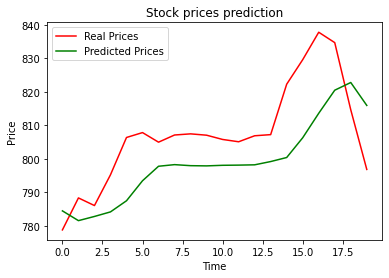

In [57]:
plt.plot(real_stock_price, color='red', label='Real Prices')
plt.plot(predicted_stock_prices, color='green', label='Predicted Prices')
plt.title("Stock prices prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
